In [86]:
import os
import time
import numpy as np
from scipy.special import softmax
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import statsmodels.api as sm

os.getcwd()

'/Users/socialai/Documents/state_punishment_May6/examples/state_punishment/notebooks'

In [87]:
# utils

def plot_quadratic_curve(x, y, ylabel, xlabel='Punishment level'):
    # Fit a quadratic curve (degree=2) to the data
    coeffs = np.polyfit(x, y, deg=2)
    poly_fn = np.poly1d(coeffs)  # Create a polynomial function

    # Generate smooth x-values and corresponding fitted y-values
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = poly_fn(x_fit)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color='blue', s=1)
    plt.plot(x_fit, y_fit, label='Fitted Quadratic Curve', color='red')
    plt.title('Scatter Plot with Fitted Quadratic Curve')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [72]:
# no visualization, run_test func
# composite visualization

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array, composite_visualization
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse
from copy import deepcopy
import torch

def run_test(
        seed,
        clear_world, 
        max_turns, 
        state_punishment_prob,
        clear_entities = None
        ):
    config_path = '../configs/config_with_vote_composite_study1.yaml'

    cfg = load_config(argparse.Namespace(config=config_path))
    cfg.env.prob.respawn_rate = 0.0
    cfg.experiment.max_turns = max_turns
    cfg.seed = seed
    clear_world = clear_world

    # set seed 
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed_all(cfg.seed)

    models = create_models(cfg)
    agents = create_agents(cfg, models)
    entities = create_entities(cfg)
    envs = []
    for i in range(len(agents)):
        envs.append(
            state_punishment(cfg, [agents[i]], deepcopy(entities))
        )


    for ixs, agent in enumerate(agents):
        if agent.ixs > -1:
            agent.model.load(
                f'../models/checkpoints/Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_agent{agent.ixs}_iRainbowModel.pkl'
            )
        else:
            agent.model = human_player.ModelHumanPlayer(
                action_space=4, 
                state_size = cfg.model.iqn.parameters.state_size, 
                extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
                memory_size=1, 
                name=f'human {ixs}')


    for epoch in range(1):
        # Reset the environment at the start of each epoch
        for env_ixs, env in enumerate(envs):
            env.reset(state_mode='composite')
            if env_ixs in clear_world:
                env.clear_world(keep_agents=True)
            env.cache['harm'] = [0 for _ in range(len(agents))]

        random.shuffle(agents)
    
        fixed_prob_dict = {'Gem': cfg.state_sys.prob_list.Gem,
                            'Coin': cfg.state_sys.prob_list.Coin,
                            'Bone': cfg.state_sys.prob_list.Bone}
        
        # initialize state system
        state_entity = state_sys(
                cfg.state_sys.init_prob, 
                fixed_prob_dict,
                cfg.state_sys.magnitude, 
                cfg.state_sys.taboo,
                cfg.state_sys.resource_punishment_is_ambiguous,
                cfg.state_sys.potential_taboo,
                cfg.state_sys.only_punish_taboo,
                cfg = cfg
                )
        

        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]
        vote_for = [0 for _ in range(len(agents))]
        vote_against = [0 for _ in range(len(agents))]
        action_values_lst = [[] for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            for env in envs:
                entities = env.get_entities_for_transition()
                # Entity transition
                for entity in entities:
                    entity.transition(env)


            # Agent transition
            for ixs, agent in enumerate(agents):

                # manually set state
                if state_punishment_prob is not None:
                    state_entity.prob = state_punishment_prob

                (state, action, reward, next_state, done_, action_values) = agent.transition(
                        envs[agent.ixs], 
                        state_entity, 
                        'certain', 
                        action_mode=cfg.action_mode,
                        state_is_composite=cfg.state_mode=='composite',
                        envs=envs,
                        is_eval=True
                        )

                action_values_lst[agent.ixs].append(action_values)
                # record vote
                if action == 4:
                    vote_for[agent.ixs] += 1
                elif action == 5:
                    vote_against[agent.ixs] += 1

            
                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                agent.add_memory(state, action, reward, done)

                game_points[agent.ixs] += reward

    return vote_for, vote_against, action_values_lst


In [77]:
# state punishment level ~ state value estimation
v_vals_mean = []
probs = []
for seed in trange(50):
    for prob in np.arange(0, 1.1, 0.1):
        _, _, action_values_lst = run_test(seed=seed,clear_world=[], max_turns=1, state_punishment_prob=prob)
        action_values_lst = [val[0].max() for val in action_values_lst]
        v_vals_mean.append(torch.stack(action_values_lst).numpy().mean())
        probs.append(prob)
# plt.plot(np.arange(0, 1.1, 0.1), v_vals_mean, 'o-')

100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


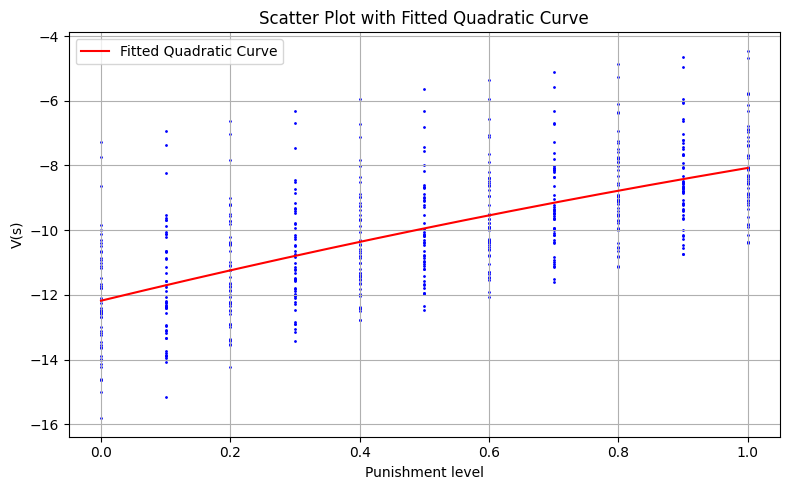

In [82]:
x = probs
y = v_vals_mean

plot_quadratic_curve(x, y)

In [84]:
# state design ~ voting intention
vote_for_prob = []
vote_against_prob = []
probs = []

for seed in trange(50):
    for prob in np.arange(0, 1.1, 0.1):
        _, _, action_values_lst = run_test(seed=seed, clear_world=[], max_turns=1, state_punishment_prob=prob)
        action_values_lst = [val[0] for val in action_values_lst]
        vote_for_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 4].mean()
        vote_against_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 5].mean()
        vote_for_prob.append(vote_for_prob_val_mean)
        vote_against_prob.append(vote_against_prob_val_mean)
        probs.append(prob)


100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.686
Method:                 Least Squares   F-statistic:                              1201.
Date:                Wed, 11 Jun 2025   Prob (F-statistic):                   2.55e-140
Time:                        13:02:53   Log-Likelihood:                          115.51
No. Observations:                 550   AIC:                                     -229.0
Df Residuals:                     549   BIC:                                     -224.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

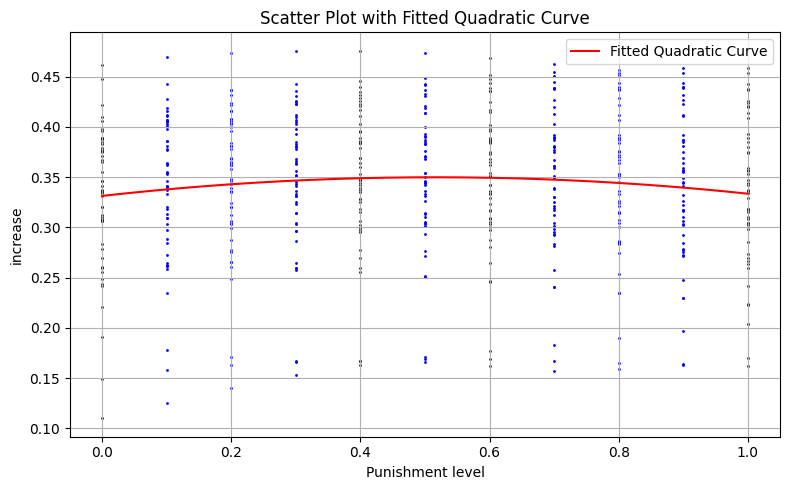

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.741
Method:                 Least Squares   F-statistic:                              1576.
Date:                Wed, 11 Jun 2025   Prob (F-statistic):                   1.77e-163
Time:                        13:02:53   Log-Likelihood:                          428.64
No. Observations:                 550   AIC:                                     -855.3
Df Residuals:                     549   BIC:                                     -851.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

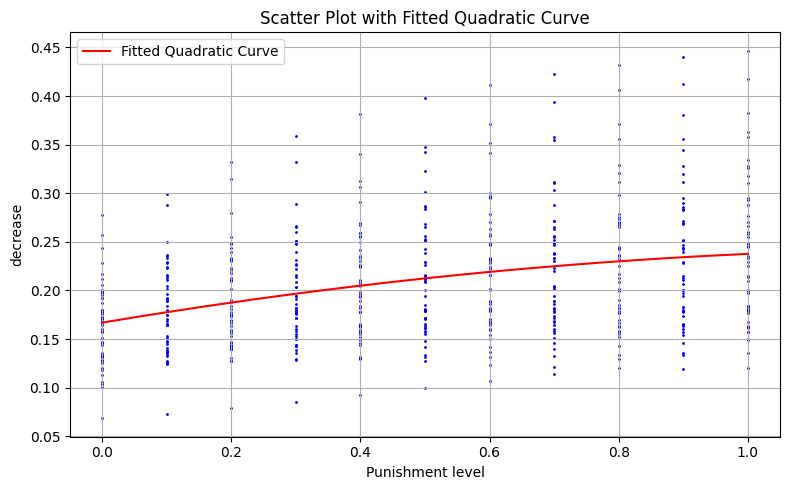

In [88]:
x = probs
y = vote_for_prob
# Fit OLS model
model = sm.OLS(y, x).fit()

# Print summary, includes p-values
print(model.summary())
plot_quadratic_curve(x, y, ylabel='increase')

y = vote_against_prob
# Fit OLS model
model = sm.OLS(y, x).fit()

# Print summary, includes p-values
print(model.summary())
plot_quadratic_curve(x, y, ylabel='decrease')

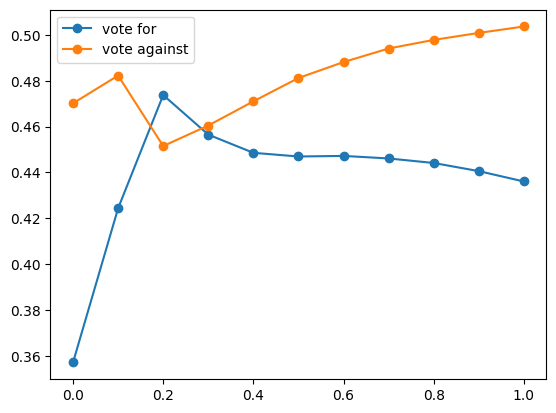

In [71]:
# state design ~ voting intention
vote_for_prob = []
vote_against_prob = []

for prob in np.arange(0, 1.1, 0.1):
    _, _, action_values_lst = run_test(clear_world=[], max_turns=1, state_punishment_prob=prob)
    action_values_lst = [val[0] for val in action_values_lst]
    vote_for_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 4].mean()
    vote_against_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 5].mean()
    vote_for_prob.append(vote_for_prob_val_mean)
    vote_against_prob.append(vote_against_prob_val_mean)
plt.plot(np.arange(0, 1.1, 0.1), vote_for_prob, 'o-', label='vote for')
plt.plot(np.arange(0, 1.1, 0.1), vote_against_prob, 'o-', label='vote against')
plt.legend()

In [28]:
vote_for, vote_against = run_test(True)
print('vote for', vote_for)
print('vote against', vote_against)

vote for [1, 30, 16]
vote against [26, 0, 10]


In [29]:
vote_for, vote_against = run_test(False)
print('vote for', vote_for)
print('vote against', vote_against)

vote for [24, 30, 3]
vote against [5, 0, 26]


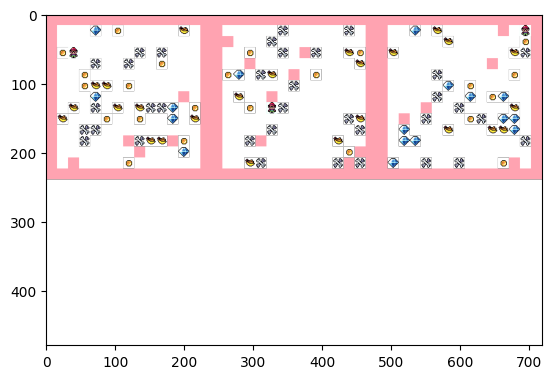

0.1
[0, 0, 0]
punishment level 0
5


KeyboardInterrupt: 

In [33]:
# composite visualization

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_with_vote_composite_study1.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array, composite_visualization
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse
from copy import deepcopy
import torch



tile_size = 32
cfg = load_config(argparse.Namespace(config=config_path))
cfg.env.prob.respawn_rate = 0.0
cfg.experiment.max_turns = 30
clear_world = False

# set seed 
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
torch.cuda.manual_seed_all(cfg.seed)

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
envs = []
for i in range(len(agents)):
    envs.append(
        state_punishment(cfg, [agents[i]], deepcopy(entities))
    )


for ixs, agent in enumerate(agents):
    if agent.ixs > -1:
        agent.model.load(
            f'../models/checkpoints/Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_agent{agent.ixs}_iRainbowModel.pkl'
        )
    else:
        agent.model = human_player.ModelHumanPlayer(
            action_space=4, 
            state_size = cfg.model.iqn.parameters.state_size, 
            extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
            memory_size=1, 
            name=f'human {ixs}')


for epoch in range(1):
    # Reset the environment at the start of each epoch
    for env_ixs, env in enumerate(envs):
        env.reset(state_mode='composite')
        if clear_world and env_ixs == 1:
            env.clear_world(keep_agents=True)
        env.cache['harm'] = [0 for _ in range(len(agents))]
    images_anim = []
    # for agent in env.agents:
    #     agent.reset(env)
    random.shuffle(agents)

    scores = GameLogger(max_epochs=1)

   
    fixed_prob_dict = {'Gem': cfg.state_sys.prob_list.Gem,
                        'Coin': cfg.state_sys.prob_list.Coin,
                        'Bone': cfg.state_sys.prob_list.Bone}
    
    # initialize state system
    state_entity = state_sys(
            cfg.state_sys.init_prob, 
            fixed_prob_dict,
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.resource_punishment_is_ambiguous,
            cfg.state_sys.potential_taboo,
            cfg.state_sys.only_punish_taboo,
            cfg = cfg
            )

    env.cache['harm'] = [0 for _ in range(len(agents))]

    done = 0 
    turn = 0
    losses = 0
    game_points = [0 for _ in range(len(agents))]
    vote_for = [0 for _ in range(len(agents))]
    vote_against = [0 for _ in range(len(agents))]

    while not done:

        turn = turn + 1

        for env in envs:
            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

        # img = visual_field_sprite(env.world, tile_size = env.tile_size)
        img = composite_visualization(envs, tile_size = tile_size)
        clear_output(wait = True)
        # scores.pretty_print(
        #      'jupyter-mode',
        #      epoch = epoch,
        #      turn = turn,
        #      reward = game_points,
        # )
        
        img = image_from_array(img)
        time.sleep(0.1)
        plt.imshow(img)
        plt.show()
        images_anim.append(img)
        print(state_entity.prob)
        print(game_points)


        # Agent transition
        for ixs, agent in enumerate(agents):

            (state, action, reward, next_state, done_) = agent.transition(
                    envs[agent.ixs], 
                    state_entity, 
                    'certain', 
                    action_mode=cfg.action_mode,
                    state_is_composite=cfg.state_mode=='composite',
                    envs=envs
                    )
            # record vote
            if action == 4:
                vote_for[agent.ixs] += 1
            elif action == 5:
                vote_against[agent.ixs] += 1

            # update state system
            print('punishment level', state_entity.level)
            if agent.ixs == 0:
                print(action)
            composite_state = agent.generate_composite_state(envs)
            # img = visual_field_sprite(env.world, tile_size = env.tile_size)
            img = composite_visualization(envs, tile_size = tile_size)
            img = image_from_array(img)
            # print(agent.model.name)
            # plt.imshow(img)
            plt.show()
            # if agent.ixs == 0:
            #      images_anim.append(img)

            if turn >= cfg.experiment.max_turns or done_:
                done = 1

            exp = (1, (composite_state, action, reward, next_state, done))
            # agent.episode_memory.append(exp)
            agent.add_memory(state, action, reward, done)

            game_points[agent.ixs] += reward

print('vote for', vote_for)
print('vote against', vote_against)


vote for [3, 27, 30]
vote against [1, 2, 0]

vote for [2, 24, 30]
vote against [3, 2, 0]

vote for [2, 21, 30]
vote against [10, 1, 0]

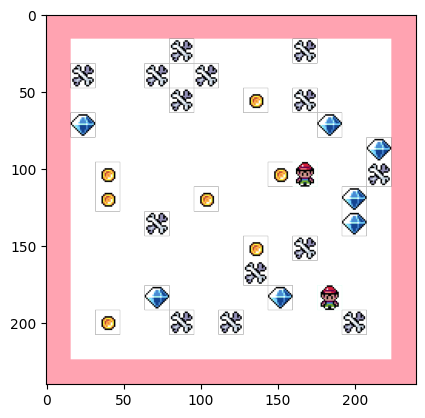

0.0
[5, 10]
Please try again. Possible actions are below.
[0 1 2 3 4 5 6 7]


UnboundLocalError: local variable 'action' referenced before assignment

In [2]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_fixed_rate_no_vote.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from examples.state_punishment.utils import inspect_the_env
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys, Monitor
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)


for ixs, agent in enumerate(agents):
    agent.model = human_player.ModelHumanPlayer(
         action_space=8, 
         state_size = cfg.model.iqn.parameters.state_size, 
         extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
         memory_size=1, 
         name=f'human {ixs}')
    # agent.model.load(
    #      f'../models/checkpoints/fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_agent{ixs}_iRainbowModel_20241127-04111732699956.pkl')
    # agent.model.load(
    #      '../models/checkpoints/fixed_punishment_rate_1.0_oneAs_size15_init_spawn_0.2_agent0_iRainbowModel.pkl'
    # )
    # agent.model.epsilon = 0.01


for epoch in range(1):
    # Reset the environment at the start of each epoch
        env.reset()
        images_anim = []
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        cfg.state_sys.prob_list = {'Gem': cfg.state_sys.prob_list.Gem,
                                   'Coin': cfg.state_sys.prob_list.Coin,
                                   'Bone': cfg.state_sys.prob_list.Bone}
        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.prob_list, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        print(state_entity.prob_list)
        
        monitor = Monitor(2, ['gem'], 15) # initiate monitor
        
        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()
            images_anim.append(img)
            print(state_entity.prob)
            print(game_points)

            # update the record of the monitor
            if monitor.time == 0:
                new_data = monitor.collect_new_state_info(env, types=None, turn=monitor.time, done=done) ##
                
                monitor.time_of_next_check()
                monitor.update(new_data) ##
                print(monitor.wait_time, monitor.check_time)
            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                # print(agent.model.name)
                # plt.imshow(img)
                plt.show()
                # if agent.ixs == 0:
                #      images_anim.append(img)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

                print(agent.location)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()

            # regular check all resources being monitored
            
            monitor.time += 1
            print(monitor.time, monitor.check_time)
            new_data = monitor.collect_new_state_info(env, types=None, turn=monitor.time, done=done) ##
            monitor.update(new_data) ##
            monitor.regular_check_all_resources(turn, state_entity, agents) ##
            monitor.time_of_next_check()
            # monitor.time_of_next_check() ##

In [ ]:
for index, _ in np.ndenumerate(env.world[:, :, 0]):
    H, W = index  # Get the coordinates
    # Return visualization image
    print(type(env.world[H, W, 0]), env.world[H, W, 0].appearance)

In [5]:
from PIL import Image
import imageio.v3 as iio
def create_gif_from_arrays(image_arrays, output_path, duration=100, loop=0):
    """
    Create a GIF from a sequence of images in NumPy array format.

    Args:
        image_arrays (list of np.ndarray): Sequence of images as NumPy arrays.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
    """
    # Convert NumPy arrays to PIL Images
    if type(image_arrays[0]) != Image.Image:
        pil_images = [Image.fromarray(img) for img in image_arrays]
    else:
        pil_images = image_arrays
    
    # Save as GIF
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


def create_gif_iio(images, output_path, fps=10):
    """
    Create a GIF from a list of image arrays using `imageio`.

    Args:
        images (list of numpy.ndarray): A list of image arrays (e.g., RGB or grayscale).
        output_path (str): Path to save the generated GIF.
        fps (int): Frames per second, controlling the speed of the GIF.
    """
    # Calculate the duration per frame in seconds
    duration_per_frame = 1 / fps
    
    # Save the GIF
    iio.imwrite(output_path, images, format="GIF", duration=duration_per_frame)
    print(f"GIF saved at {output_path}")


from PIL import Image, ImageDraw

from PIL import Image

def create_gif_from_pil_force_clean(image_list, output_path, duration=100, loop=0, background_color=(255, 255, 255)):
    """
    Create a GIF from a list of `PIL.Image.Image` objects, ensuring no shadow artifacts.
    Ensures each frame has a fresh background.

    Args:
        image_list (list of PIL.Image.Image): Sequence of PIL images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
        background_color (tuple): RGB color to reset the background for each frame.
    """
    # Determine the size of the images
    width, height = image_list[0].size

    # Ensure all frames are re-rendered on a clean background
    cleaned_frames = []
    for img in image_list:
        # Create a blank canvas for each frame
        blank_frame = Image.new(mode=img.mode, size=(width, height), color=background_color)
        
        # Convert the image to RGBA to handle transparency (if needed)
        if img.mode != "RGBA":
            img = img.convert("RGBA")
        
        # Paste the current frame onto the blank canvas
        blank_frame.paste(img, (0, 0), mask=img if img.mode == "RGBA" else None)
        cleaned_frames.append(blank_frame)

    # Save as GIF
    cleaned_frames[0].save(
        output_path,
        save_all=True,
        append_images=cleaned_frames[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


In [6]:
# from examples.state_punishment.utils import create_gif_from_arrays
print(type(images_anim[0]) == Image.Image)
create_gif_from_pil_force_clean(images_anim, 'test_parallel_envs.gif', 200)


True
GIF saved at test_parallel_envs.gif
